# MinHash 算法实现（从零开始）

MinHash 是一种用于快速估计文档相似性的局部敏感哈希算法，特别适合用于检测集合的Jaccard相似度。与SimHash不同，MinHash主要用于处理集合的相似性，而不是向量的相似性。本notebook从零开始实现MinHash算法，不依赖任何专门的MinHash库。

## MinHash 算法原理

MinHash算法的基本思想是通过随机置换的方式，将集合映射成一个签名（signature），使得两个集合的签名相似度近似等于它们的Jaccard相似度。

MinHash算法的基本步骤如下：

1. **特征提取**：将文本分割成多个特征（如单词、n-gram等）
2. **特征集合构建**：将特征转换为集合
3. **哈希函数生成**：生成多个随机哈希函数
4. **签名计算**：对每个集合计算MinHash签名
5. **相似度估计**：通过比较签名来估计集合的Jaccard相似度

我们将使用Python从零开始实现这个算法，并与之前实现的SimHash进行对比。

## 1. 安装必要的库

首先，我们安装必要的库，但不会使用专门的MinHash库。

In [1]:
# 安装必要的库
!pip install jieba numpy matplotlib datasketch --quiet

## 2. 导入库

In [2]:
import jieba  # 用于中文分词
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import random
import requests
from bs4 import BeautifulSoup
import time
import hashlib

## 3. 实现特征提取函数

与SimHash类似，我们首先需要从文本中提取特征。

In [3]:
def extract_features(text, use_ngram=False, ngram_size=3):
    """
    从文本中提取特征。
    如果 use_ngram 为 True 且 ngram_size > 1，则生成词级别的 n-gram。
    否则，生成词级别的 unigram (单个词)。
    对于中文，使用jieba分词。
    对于英文，使用空格分词。
    
    参数:
    - text: 输入文本
    - use_ngram: 是否使用n-gram
    - ngram_size: n-gram的大小 (如果 use_ngram=True)
    
    返回:
    - 特征列表 (字符串列表)
    """
    text = text.lower()  # 转为小写
    
    words = []
    # 判断是否包含中文字符
    is_chinese = any('\u4e00' <= char <= '\u9fff' for char in text)
    
    if is_chinese:
        # 对中文使用jieba分词
        # jieba 应该在文件顶部导入
        words = [word for word in jieba.cut(text) if word.strip()]
    else:
        # 对英文或其他语言使用简单的分词
        processed_text = re.sub(r'[^\w\s]', '', text)  # 移除标点
        processed_text = re.sub(r'\s+', ' ', processed_text).strip()  # 标准化空格
        words = [word for word in processed_text.split() if word.strip()]

    if use_ngram and ngram_size > 1 and words:
        if len(words) < ngram_size:
            # 如果词数不足以构成一个n-gram，可以将所有词合并为一个特征
            return ["_".join(words)] 
        # 生成词级别的 n-gram，用下划线连接
        return ["_".join(words[i:i+ngram_size]) for i in range(len(words) - ngram_size + 1)]
    elif words: # 返回 unigrams (单个词)
        return words
    else: # 如果没有词
        return []

## 4. MinHash 算法核心实现

MinHash 算法的核心是生成多个哈希函数，然后对集合中的每个元素计算最小哈希值。

In [4]:
class MinHash:
    """
    MinHash 算法实现
    """
    
    def __init__(self, num_perm=128, seed=42):
        """
        初始化 MinHash
        
        参数:
        - num_perm: 置换（哈希函数）的数量
        - seed: 随机种子
        """
        self.num_perm = num_perm
        self.seed = seed
        
        # 生成随机哈希函数的参数
        random.seed(seed)
        
        # 对于每个哈希函数，我们使用形如 (a*x + b) % c 的哈希函数
        # 其中 a, b 是随机数，c 是一个大素数
        self.c = (1 << 31) - 1  # 一个大素数
        self.a = [random.randint(1, self.c - 1) for _ in range(num_perm)]
        self.b = [random.randint(0, self.c - 1) for _ in range(num_perm)]

    def _hash_element(self, element, idx):
        """
        使用第 idx 个哈希函数计算元素的哈希值
        
        参数:
        - element: 元素
        - idx: 哈希函数索引
        
        返回:
        - 哈希值
        """
        # 使用 MurmurHash 或其他哈希函数将元素转换为整数
        # 这里简单使用 md5 哈希值的整数表示
        element_bytes = element.encode('utf-8')
        element_hash = int(hashlib.md5(element_bytes).hexdigest(), 16)
        
        # 应用哈希函数 h(x) = (a*x + b) % c
        return ((self.a[idx] * element_hash + self.b[idx]) % self.c)

    def compute_signature(self, features):
        """
        计算特征集合的 MinHash 签名
        
        参数:
        - features: 特征列表/集合
        
        返回:
        - MinHash 签名（长度为 num_perm 的数组）
        """
        if not features:
            return [float('inf')] * self.num_perm
        
        # 初始化签名为无穷大
        signature = [float('inf')] * self.num_perm
        
        # 对每个特征
        for feature in features:
            # 对每个哈希函数
            for i in range(self.num_perm):
                # 计算哈希值
                hash_value = self._hash_element(feature, i)
                # 更新最小值
                signature[i] = min(signature[i], hash_value)
        
        return signature

    @staticmethod
    def jaccard_similarity(set1, set2):
        """
        计算两个集合的 Jaccard 相似度
        
        参数:
        - set1: 第一个集合
        - set2: 第二个集合
        
        返回:
        - Jaccard 相似度 (0 到 1 之间)
        """
        set1 = set(set1)
        set2 = set(set2)
        
        # Jaccard 相似度 = 交集大小 / 并集大小
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        
        # 避免除零错误
        if union == 0:
            return 0.0
        
        return intersection / union

    def estimate_similarity(self, signature1, signature2):
        """
        通过 MinHash 签名估计两个集合的 Jaccard 相似度
        
        参数:
        - signature1: 第一个 MinHash 签名
        - signature2: 第二个 MinHash 签名
        
        返回:
        - 估计的 Jaccard 相似度 (0 到 1 之间)
        """
        if len(signature1) != len(signature2):
            raise ValueError("签名长度不一致")
        
        # 估计的 Jaccard 相似度 = 签名匹配的比例
        matches = sum(1 for i in range(len(signature1)) if signature1[i] == signature2[i])
        return matches / len(signature1)

## 5. 测试 MinHash 算法

现在，我们来测试我们实现的 MinHash 算法。

### 5.1 准备测试文本

In [5]:
# 准备不同的示例文本
text1 = "你好，欢迎来到筱可AI研习社，我们一起学习人工智能。"
text2 = "你好，欢迎来到筱可AI研习社，我们一同学习人工智能技术。"  # 与text1相似
text3 = "今天天气真不错，阳光明媚。"  # 与text1完全不同
text4 = "你好，欢迎来到筱可AI研习社，我们一起学习人工智能。"  # 与text1完全相同
text5 = "Hello, welcome to Xiaoke AI Labs, let's learn artificial intelligence together."  # 英文，与text1意思相近

# 打印测试文本
print("示例文本:")
print(f"文本1: {text1}")
print(f"文本2: {text2}")
print(f"文本3: {text3}")
print(f"文本4: {text4}")
print(f"文本5: {text5}")

示例文本:
文本1: 你好，欢迎来到筱可AI研习社，我们一起学习人工智能。
文本2: 你好，欢迎来到筱可AI研习社，我们一同学习人工智能技术。
文本3: 今天天气真不错，阳光明媚。
文本4: 你好，欢迎来到筱可AI研习社，我们一起学习人工智能。
文本5: Hello, welcome to Xiaoke AI Labs, let's learn artificial intelligence together.


### 5.2 提取特征并计算 Jaccard 相似度

In [6]:
# 提取特征
features1 = extract_features(text1)
features2 = extract_features(text2)
features3 = extract_features(text3)
features4 = extract_features(text4)
features5 = extract_features(text5, use_ngram=True)

print("提取的特征:")
print(f"文本1特征: {features1}")
print(f"文本2特征: {features2}")
print(f"文本3特征: {features3}")
print(f"文本4特征: {features4}")
print(f"文本5特征(前10个): {features5[:10]}...")

# 计算实际的 Jaccard 相似度
jac_sim_1_2 = MinHash.jaccard_similarity(features1, features2)
jac_sim_1_3 = MinHash.jaccard_similarity(features1, features3)
jac_sim_1_4 = MinHash.jaccard_similarity(features1, features4)
jac_sim_1_5 = MinHash.jaccard_similarity(features1, features5)

print("\n实际的 Jaccard 相似度:")
print(f"文本1和文本2: {jac_sim_1_2:.4f}")
print(f"文本1和文本3: {jac_sim_1_3:.4f}")
print(f"文本1和文本4: {jac_sim_1_4:.4f} (完全相同)")
print(f"文本1和文本5: {jac_sim_1_5:.4f} (中英文表达相同意思)")

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\k\AppData\Local\Temp\jieba.cache
Loading model cost 0.793 seconds.
Prefix dict has been built successfully.


提取的特征:
文本1特征: ['你好', '，', '欢迎', '来到', '筱可', 'ai', '研习', '社', '，', '我们', '一起', '学习', '人工智能', '。']
文本2特征: ['你好', '，', '欢迎', '来到', '筱可', 'ai', '研习', '社', '，', '我们', '一同', '学习', '人工智能', '技术', '。']
文本3特征: ['今天天气', '真不错', '，', '阳光明媚', '。']
文本4特征: ['你好', '，', '欢迎', '来到', '筱可', 'ai', '研习', '社', '，', '我们', '一起', '学习', '人工智能', '。']
文本5特征(前10个): ['hello_welcome_to', 'welcome_to_xiaoke', 'to_xiaoke_ai', 'xiaoke_ai_labs', 'ai_labs_lets', 'labs_lets_learn', 'lets_learn_artificial', 'learn_artificial_intelligence', 'artificial_intelligence_together']...

实际的 Jaccard 相似度:
文本1和文本2: 0.8000
文本1和文本3: 0.1250
文本1和文本4: 1.0000 (完全相同)
文本1和文本5: 0.0000 (中英文表达相同意思)


### 5.3 计算 MinHash 签名并估计相似度

In [7]:
# 初始化 MinHash
minhash = MinHash(num_perm=128)

# 计算 MinHash 签名
signature1 = minhash.compute_signature(features1)
signature2 = minhash.compute_signature(features2)
signature3 = minhash.compute_signature(features3)
signature4 = minhash.compute_signature(features4)
signature5 = minhash.compute_signature(features5)

print("MinHash 签名长度:")
print(f"文本1: {len(signature1)}")
print(f"文本2: {len(signature2)}")
print(f"文本3: {len(signature3)}")
print(f"文本4: {len(signature4)}")
print(f"文本5: {len(signature5)}")

# 估计 Jaccard 相似度
est_sim_1_2 = minhash.estimate_similarity(signature1, signature2)
est_sim_1_3 = minhash.estimate_similarity(signature1, signature3)
est_sim_1_4 = minhash.estimate_similarity(signature1, signature4)
est_sim_1_5 = minhash.estimate_similarity(signature1, signature5)

print("\nMinHash 估计的 Jaccard 相似度:")
print(f"文本1和文本2: {est_sim_1_2:.4f}")
print(f"文本1和文本3: {est_sim_1_3:.4f}")
print(f"文本1和文本4: {est_sim_1_4:.4f} (完全相同)")
print(f"文本1和文本5: {est_sim_1_5:.4f} (中英文表达相同意思)")

MinHash 签名长度:
文本1: 128
文本2: 128
文本3: 128
文本4: 128
文本5: 128

MinHash 估计的 Jaccard 相似度:
文本1和文本2: 0.8359
文本1和文本3: 0.1016
文本1和文本4: 1.0000 (完全相同)
文本1和文本5: 0.0000 (中英文表达相同意思)


### 5.4 对比 MinHash 估计值与实际 Jaccard 相似度

In [8]:
# 创建比较表格数据
comparisons = [
    ["文本1 vs 文本2", jac_sim_1_2, est_sim_1_2, abs(jac_sim_1_2 - est_sim_1_2)],
    ["文本1 vs 文本3", jac_sim_1_3, est_sim_1_3, abs(jac_sim_1_3 - est_sim_1_3)],
    ["文本1 vs 文本4", jac_sim_1_4, est_sim_1_4, abs(jac_sim_1_4 - est_sim_1_4)],
    ["文本1 vs 文本5", jac_sim_1_5, est_sim_1_5, abs(jac_sim_1_5 - est_sim_1_5)]
]

# 转换为 NumPy 数组以便于操作
comparisons_array = np.array(comparisons, dtype=object)

print("相似度比较:")
print("比较对象 | 实际 Jaccard | MinHash 估计 | 绝对误差")
print("-" * 60)
for row in comparisons_array:
    print(f"{row[0]:15} | {row[1]:.4f} | {row[2]:.4f} | {row[3]:.4f}")

相似度比较:
比较对象 | 实际 Jaccard | MinHash 估计 | 绝对误差
------------------------------------------------------------
文本1 vs 文本2      | 0.8000 | 0.8359 | 0.0359
文本1 vs 文本3      | 0.1250 | 0.1016 | 0.0234
文本1 vs 文本4      | 1.0000 | 1.0000 | 0.0000
文本1 vs 文本5      | 0.0000 | 0.0000 | 0.0000


## 6. LSH (Locality-Sensitive Hashing) 实现

MinHash 常与 LSH (Locality-Sensitive Hashing) 结合使用，以实现大规模数据集的快速相似性搜索。下面我们实现一个简单的 LSH 索引。

In [9]:
class MinHashLSH:
    """
    基于 MinHash 的 LSH 索引实现
    """
    
    def __init__(self, minhash, threshold=0.5, bands=16):
        """
        初始化 LSH 索引
        
        参数:
        - minhash: MinHash 实例
        - threshold: 相似度阈值
        - bands: 分区数量
        """
        self.minhash = minhash
        self.threshold = threshold
        self.bands = bands
        
        # 确保能整除
        if minhash.num_perm % bands != 0:
            raise ValueError(f"num_perm ({minhash.num_perm}) 必须能被 bands ({bands}) 整除")
        
        self.rows = minhash.num_perm // bands
        self.tables = [{} for _ in range(bands)]
        self.doc_to_signature = {}

    def _get_band_hash(self, signature, band_idx):
        """
        计算一个签名分区的哈希值
        
        参数:
        - signature: MinHash 签名
        - band_idx: 分区索引
        
        返回:
        - 分区哈希值
        """
        start = band_idx * self.rows
        end = start + self.rows
        band = tuple(signature[start:end])
        return hash(band)

    def add(self, doc_id, features):
        """
        将文档添加到索引
        
        参数:
        - doc_id: 文档ID
        - features: 文档特征
        """
        # 计算签名
        signature = self.minhash.compute_signature(features)
        self.doc_to_signature[doc_id] = signature
        
        # 添加到各个分区
        for band_idx in range(self.bands):
            band_hash = self._get_band_hash(signature, band_idx)
            
            if band_hash not in self.tables[band_idx]:
                self.tables[band_idx][band_hash] = []
            
            self.tables[band_idx][band_hash].append(doc_id)

    def query(self, features):
        """
        查询与给定特征相似的文档
        
        参数:
        - features: 查询特征
        
        返回:
        - 可能相似的文档ID列表
        """
        query_signature = self.minhash.compute_signature(features)
        candidates = set()
        
        # 查询各个分区
        for band_idx in range(self.bands):
            band_hash = self._get_band_hash(query_signature, band_idx)
            
            if band_hash in self.tables[band_idx]:
                candidates.update(self.tables[band_idx][band_hash])
        
        # 计算实际的相似度并过滤
        results = []
        for doc_id in candidates:
            doc_signature = self.doc_to_signature[doc_id]
            similarity = self.minhash.estimate_similarity(query_signature, doc_signature)
            
            if similarity >= self.threshold:
                results.append((doc_id, similarity))
        
        # 按相似度排序
        results.sort(key=lambda x: x[1], reverse=True)
        
        return results

## 7. 使用 LSH 进行批量查重测试

In [10]:
# 准备一组用于测试的文档
documents = [
    "这是一篇关于机器学习的文章。",
    "机器学习是人工智能的一个分支。",
    "深度学习是机器学习的一个重要领域。",
    "这是一篇关于机器学习的文章，讨论了其最新进展。",  # 与第一篇相似
    "自然语言处理是人工智能的另一个重要方向。",
    "今天的天气非常晴朗。",
    "这是一篇关于机器学习的文章。"  # 与第一篇完全相同
]

# 打印测试文档
print("测试文档集:")
for i, doc in enumerate(documents):
    print(f"文档 {i}: {doc}")

测试文档集:
文档 0: 这是一篇关于机器学习的文章。
文档 1: 机器学习是人工智能的一个分支。
文档 2: 深度学习是机器学习的一个重要领域。
文档 3: 这是一篇关于机器学习的文章，讨论了其最新进展。
文档 4: 自然语言处理是人工智能的另一个重要方向。
文档 5: 今天的天气非常晴朗。
文档 6: 这是一篇关于机器学习的文章。


In [11]:
# 创建 MinHash 和 LSH 索引
minhash = MinHash(num_perm=128)
lsh = MinHashLSH(minhash, threshold=0.5, bands=16)

# 将文档添加到 LSH 索引
for i, doc in enumerate(documents):
    features = extract_features(doc)
    lsh.add(i, features)

print(f"已将 {len(documents)} 个文档添加到 LSH 索引")

已将 7 个文档添加到 LSH 索引


In [12]:
# 查询新文档
query_doc = "这是一篇讨论机器学习最新进展的文章。"
print(f"查询文档: {query_doc}")

query_features = extract_features(query_doc)
results = lsh.query(query_features)

print("\n查询结果:")
if results:
    for doc_id, similarity in results:
        print(f"- 文档 {doc_id}: '{documents[doc_id]}'")
        print(f"  估计相似度: {similarity:.4f}")
        
        # 计算实际 Jaccard 相似度进行比较
        doc_features = extract_features(documents[doc_id])
        actual_similarity = MinHash.jaccard_similarity(query_features, doc_features)
        print(f"  实际 Jaccard 相似度: {actual_similarity:.4f}")
else:
    print("未找到相似文档")

查询文档: 这是一篇讨论机器学习最新进展的文章。

查询结果:
- 文档 0: '这是一篇关于机器学习的文章。'
  估计相似度: 0.6641
  实际 Jaccard 相似度: 0.7000
- 文档 6: '这是一篇关于机器学习的文章。'
  估计相似度: 0.6641
  实际 Jaccard 相似度: 0.7000


## 8. 性能测试：MinHash vs SimHash

下面我们将测试 MinHash 和 SimHash 在速度和准确性方面的性能表现。

In [13]:
# 导入 SimHash 实现（假设您已经在其他 notebook 中实现了）
# 这里重新简单实现一个 SimHash 以便对比

def simhash(features, weights=None, hash_bits=64):
    """简化版 SimHash 实现，用于性能比较"""
    if not features:
        return 0
    
    if weights is None:
        weights = {feature: 1.0 for feature in features}
    
    v = [0] * hash_bits
    
    for feature in features:
        h = hashlib.md5(feature.encode('utf-8')).hexdigest()
        feature_hash = bin(int(h, 16))[2:].zfill(hash_bits)
        if len(feature_hash) > hash_bits:
            feature_hash = feature_hash[:hash_bits]
        
        weight = weights.get(feature, 1.0)
        
        for i in range(min(hash_bits, len(feature_hash))):
            if feature_hash[i] == '1':
                v[i] += weight
            else:
                v[i] -= weight
    
    fingerprint = 0
    for i in range(hash_bits):
        if v[i] > 0:
            fingerprint += (1 << i)
    
    return fingerprint

def calculate_weights(features):
    """简化版权重计算函数"""
    counter = Counter(features)
    total = sum(counter.values())
    return {feature: count / total for feature, count in counter.items()}

def hamming_distance(hash1, hash2):
    """计算汉明距离"""
    xor_result = hash1 ^ hash2
    return bin(xor_result).count('1')

def simhash_similarity(hash1, hash2, hash_bits=64):
    """计算基于 SimHash 的相似度"""
    distance = hamming_distance(hash1, hash2)
    return 1.0 - (distance / hash_bits)

In [14]:
# 生成测试文档
import random
import string

def generate_random_document(length=100):
    """生成随机文档"""
    return ' '.join(''.join(random.choice(string.ascii_lowercase) for _ in range(random.randint(3, 8)))
                  for _ in range(length))

def generate_similar_document(doc, change_ratio=0.2):
    """生成与原文档相似的文档"""
    words = doc.split()
    num_to_change = int(len(words) * change_ratio)
    indices = random.sample(range(len(words)), num_to_change)
    
    for idx in indices:
        words[idx] = ''.join(random.choice(string.ascii_lowercase) for _ in range(random.randint(3, 8)))
    
    return ' '.join(words)

# 生成测试数据
num_docs = 100
documents = [generate_random_document() for _ in range(num_docs)]
query_docs = [generate_similar_document(doc) for doc in documents[:10]]  # 生成10个相似查询

In [15]:
# 性能测试函数
def test_minhash_performance():
    """测试 MinHash 性能"""
    start_time = time.time()
    
    # 初始化 MinHash
    minhash = MinHash(num_perm=128)
    lsh = MinHashLSH(minhash, threshold=0.5, bands=16)
    
    # 添加文档
    for i, doc in enumerate(documents):
        features = extract_features(doc)
        lsh.add(i, features)
    
    # 查询
    results = []
    for query in query_docs:
        query_features = extract_features(query)
        results.append(lsh.query(query_features))
    
    end_time = time.time()
    return end_time - start_time, results

def test_simhash_performance():
    """测试 SimHash 性能"""
    start_time = time.time()
    
    # 计算文档的 SimHash
    doc_hashes = []
    for doc in documents:
        features = extract_features(doc)
        weights = calculate_weights(features)
        doc_hash = simhash(features, weights)
        doc_hashes.append(doc_hash)
    
    # 查询
    results = []
    for query in query_docs:
        query_features = extract_features(query)
        query_weights = calculate_weights(query_features)
        query_hash = simhash(query_features, query_weights)
        
        # 计算与所有文档的相似度
        similarities = [(i, simhash_similarity(query_hash, doc_hash)) 
                        for i, doc_hash in enumerate(doc_hashes)]
        
        # 过滤并排序相似文档
        similar_docs = [(i, sim) for i, sim in similarities if sim >= 0.5]
        similar_docs.sort(key=lambda x: x[1], reverse=True)
        results.append(similar_docs)
    
    end_time = time.time()
    return end_time - start_time, results

In [16]:
# 运行性能测试
minhash_time, minhash_results = test_minhash_performance()
simhash_time, simhash_results = test_simhash_performance()

print(f"MinHash 处理时间: {minhash_time:.4f}秒")
print(f"SimHash 处理时间: {simhash_time:.4f}秒")

# 简单分析一下结果
print("\n结果分析:")
for i in range(min(3, len(query_docs))):  # 只看前三个查询结果
    print(f"\n查询文档 {i}:")
    print(f"MinHash 找到 {len(minhash_results[i])} 个相似文档")
    if minhash_results[i]:
        top_minhash = minhash_results[i][0]
        print(f"MinHash 最相似的文档: ID={top_minhash[0]}, 相似度={top_minhash[1]:.4f}")
    
    print(f"SimHash 找到 {len(simhash_results[i])} 个相似文档")
    if simhash_results[i]:
        top_simhash = simhash_results[i][0]
        print(f"SimHash 最相似的文档: ID={top_simhash[0]}, 相似度={top_simhash[1]:.4f}")

MinHash 处理时间: 2.7352秒
SimHash 处理时间: 0.1103秒

结果分析:

查询文档 0:
MinHash 找到 0 个相似文档
SimHash 找到 59 个相似文档
SimHash 最相似的文档: ID=0, 相似度=0.9375

查询文档 1:
MinHash 找到 0 个相似文档
SimHash 找到 65 个相似文档
SimHash 最相似的文档: ID=1, 相似度=0.7969

查询文档 2:
MinHash 找到 0 个相似文档
SimHash 找到 54 个相似文档
SimHash 最相似的文档: ID=2, 相似度=0.7969


## 9. MinHash 与真实文本

让我们使用真实的文本测试 MinHash 的效果。

In [17]:
# 从维基百科获取文章内容
url = "https://en.wikipedia.org/wiki/Machine_learning"
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    content = soup.find('div', {'id': 'mw-content-text'})
    
    if content:
        # 清理内容，移除不需要的元素
        for element in content.find_all(['table', 'style', 'script', 'sup', 'span']):
            element.decompose()
        
        # 提取段落文本
        paragraphs = content.find_all('p')
        wiki_text = ' '.join([p.get_text() for p in paragraphs])
        
        # 清理文本
        wiki_text = ' '.join(wiki_text.split())
        print(f"获取到维基百科文本，长度: {len(wiki_text)} 字符")
        print(f"文本预览: {wiki_text[:100]}...")
    else:
        print("无法找到主要内容")
        wiki_text = "Machine learning is a field of study that focuses on algorithms and statistical models that computers use to perform tasks without explicit instructions."
else:
    print(f"请求失败: {response.status_code}")
    wiki_text = "Machine learning is a field of study that focuses on algorithms and statistical models that computers use to perform tasks without explicit instructions."

获取到维基百科文本，长度: 57725 字符
文本预览: Machine learning (ML) is a field of study in artificial intelligence concerned with the development ...


### 9.1 文本变化敏感性测试

和 SimHash 实验类似，我们测试 MinHash 对文本渐进变化的敏感性。

In [18]:
# 提取原始文本特征
wiki_features = extract_features(wiki_text, use_ngram=True)
print(f"原始文本特征数量: {len(wiki_features)}")
print(f"前10个特征示例: {wiki_features[:10]}")

# 创建 MinHash 实例
minhash = MinHash(num_perm=256)
original_signature = minhash.compute_signature(wiki_features)

# 模拟文本变化函数
def simulate_text_change(features, change_percent):
    """模拟文本变化，通过随机删除一定比例的特征"""
    num_to_remove = int(len(features) * change_percent / 100)
    modified_features = features.copy()
    
    if num_to_remove > 0:
        indices_to_remove = random.sample(range(len(features)), num_to_remove)
        modified_features = [feat for i, feat in enumerate(features) if i not in indices_to_remove]
    
    return modified_features

原始文本特征数量: 8452
前10个特征示例: ['machine_learning_ml', 'learning_ml_is', 'ml_is_a', 'is_a_field', 'a_field_of', 'field_of_study', 'of_study_in', 'study_in_artificial', 'in_artificial_intelligence', 'artificial_intelligence_concerned']


In [19]:
# 设置不同的文本变化比例
change_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
minhash_similarities = []
jaccard_similarities = []

# 对每个变化比例执行实验
for percent in change_percentages:
    # 模拟文本变化
    modified_features = simulate_text_change(wiki_features, percent)
    print(f"文本变化{percent}%后特征数量: {len(modified_features)}")
    
    # 计算修改后的 MinHash 签名
    modified_signature = minhash.compute_signature(modified_features)
    
    # 计算 MinHash 估计相似度
    minhash_similarity = minhash.estimate_similarity(original_signature, modified_signature)
    
    # 计算实际 Jaccard 相似度
    jaccard_similarity = MinHash.jaccard_similarity(wiki_features, modified_features)
    
    # 记录结果
    minhash_similarities.append(minhash_similarity)
    jaccard_similarities.append(jaccard_similarity)
    
    print(f"文本变化{percent}%: MinHash相似度 = {minhash_similarity:.4f}, Jaccard相似度 = {jaccard_similarity:.4f}")

文本变化10%后特征数量: 7607
文本变化10%: MinHash相似度 = 0.9141, Jaccard相似度 = 0.9036
文本变化20%后特征数量: 6762
文本变化20%: MinHash相似度 = 0.7891, Jaccard相似度 = 0.8076
文本变化30%后特征数量: 5917
文本变化30%: MinHash相似度 = 0.7500, Jaccard相似度 = 0.7092
文本变化40%后特征数量: 5072
文本变化40%: MinHash相似度 = 0.6172, Jaccard相似度 = 0.6094
文本变化50%后特征数量: 4226
文本变化50%: MinHash相似度 = 0.4883, Jaccard相似度 = 0.5108
文本变化60%后特征数量: 3381
文本变化60%: MinHash相似度 = 0.4062, Jaccard相似度 = 0.4110
文本变化70%后特征数量: 2536
文本变化70%: MinHash相似度 = 0.2930, Jaccard相似度 = 0.3108
文本变化80%后特征数量: 1691
文本变化80%: MinHash相似度 = 0.1914, Jaccard相似度 = 0.2082
文本变化90%后特征数量: 846
文本变化90%: MinHash相似度 = 0.0938, Jaccard相似度 = 0.1051


### 9.2 可视化实验结果

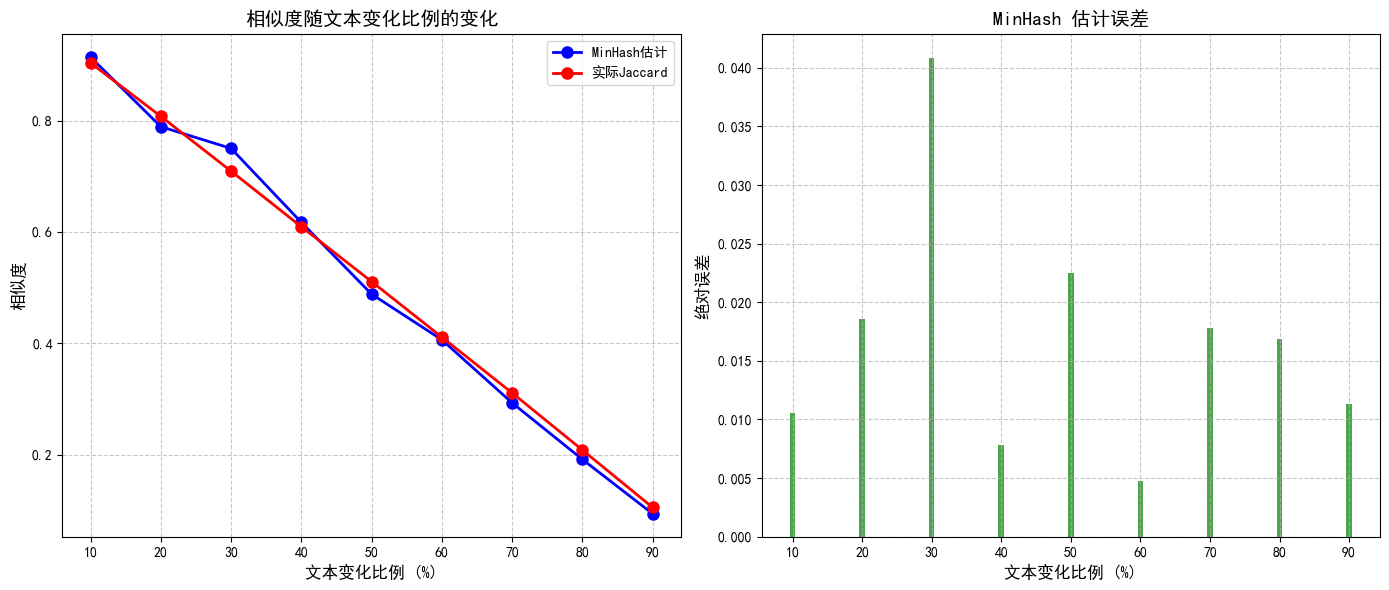

In [20]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

# 设置图表
plt.figure(figsize=(14, 6))

# 绘制 MinHash 和 Jaccard 相似度随变化比例的变化
plt.subplot(1, 2, 1)
plt.plot(change_percentages, minhash_similarities, 'bo-', linewidth=2, markersize=8, label='MinHash估计')
plt.plot(change_percentages, jaccard_similarities, 'ro-', linewidth=2, markersize=8, label='实际Jaccard')
plt.title('相似度随文本变化比例的变化', fontsize=14)
plt.xlabel('文本变化比例 (%)', fontsize=12)
plt.ylabel('相似度', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(change_percentages)

# 绘制估计误差
plt.subplot(1, 2, 2)
errors = [abs(minhash_similarities[i] - jaccard_similarities[i]) for i in range(len(change_percentages))]
plt.bar(change_percentages, errors, color='green', alpha=0.7)
plt.title('MinHash 估计误差', fontsize=14)
plt.xlabel('文本变化比例 (%)', fontsize=12)
plt.ylabel('绝对误差', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(change_percentages)

plt.tight_layout()
plt.show()

## 10. MinHash 和 SimHash 对比

下面我们对比 MinHash 和 SimHash 在文本相似度检测方面的特点。

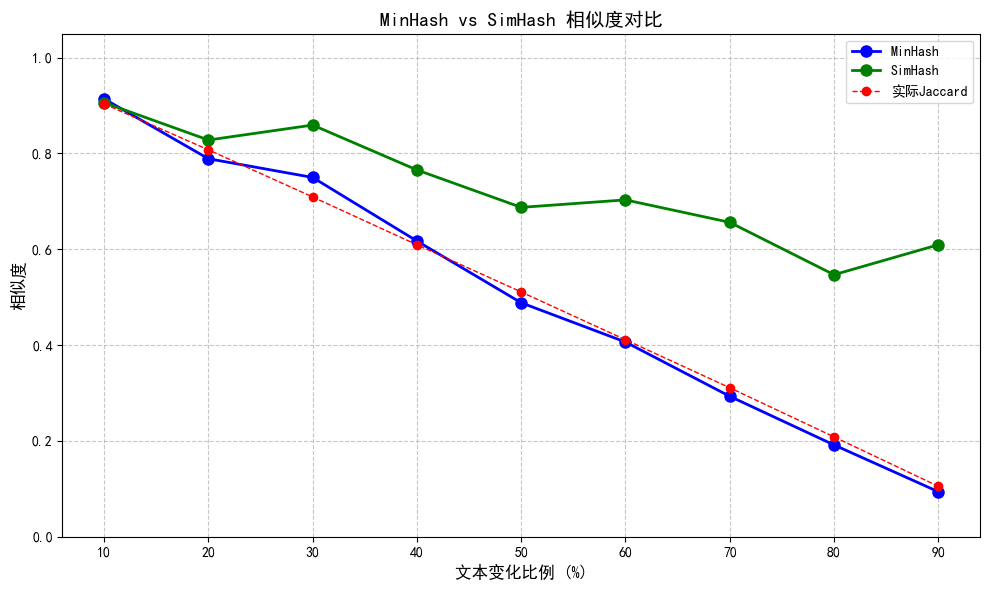

In [21]:
# 计算 MinHash 和 SimHash 在不同变化比例下的相似度
# 使用之前的实验数据

# 创建 SimHash 计算函数
def calculate_simhash_similarity(original_features, modified_features):
    """计算 SimHash 相似度"""
    orig_weights = calculate_weights(original_features)
    mod_weights = calculate_weights(modified_features)
    
    orig_hash = simhash(original_features, orig_weights)
    mod_hash = simhash(modified_features, mod_weights)
    
    return simhash_similarity(orig_hash, mod_hash)

# 计算不同变化比例下的 SimHash 相似度
simhash_similarities = []

for percent in change_percentages:
    modified_features = simulate_text_change(wiki_features, percent)
    sim_similarity = calculate_simhash_similarity(wiki_features, modified_features)
    simhash_similarities.append(sim_similarity)

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(change_percentages, minhash_similarities, 'bo-', linewidth=2, markersize=8, label='MinHash')
plt.plot(change_percentages, simhash_similarities, 'go-', linewidth=2, markersize=8, label='SimHash')
plt.plot(change_percentages, jaccard_similarities, 'ro--', linewidth=1, markersize=6, label='实际Jaccard')

plt.title('MinHash vs SimHash 相似度对比', fontsize=14)
plt.xlabel('文本变化比例 (%)', fontsize=12)
plt.ylabel('相似度', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(change_percentages)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

## 11. 总结与对比分析

本实验中，我们从零实现了 MinHash 算法，并与 SimHash 算法进行了对比。下面是两种算法的特点比较：

### MinHash 特点
1. **原理**: 基于随机置换和最小哈希值，估计集合间的 Jaccard 相似度
2. **优势**: 
   - 对集合操作（如交集、并集）有良好的数学保证
   - 可以通过增加置换数量提高估计准确性
   - 结合 LSH 可实现高效的近似最近邻搜索
3. **局限性**:
   - 不考虑特征权重（每个特征同等重要）
   - 计算开销随置换数量增加而线性增加
   - 对小文档的效果较差

### SimHash 特点
1. **原理**: 将特征映射到向量空间，然后将加权向量合并为一个固定长度的指纹
2. **优势**:
   - 考虑特征权重，重要特征对结果影响更大
   - 生成的指纹固定长度，存储效率高
   - 计算汉明距离非常快速
3. **局限性**:
   - 没有严格的数学保证（如 MinHash 估计 Jaccard 相似度）
   - 对特征权重的选择敏感
   - 难以调整精度（通常通过增加位数）

### 应用场景建议
1. **MinHash 适合**: 
   - 大规模集合相似度计算
   - 需要理论保证的场景
   - 搭配 LSH 做大数据集的近似最近邻搜索

2. **SimHash 适合**:
   - 网页去重、文档查重等需要快速比较的场景
   - 需要考虑特征权重的场景
   - 存储空间有限但需要保存大量指纹的场景

在实际应用中，可以根据具体需求选择合适的算法，或者将两种算法结合使用，取长补短。